In [1]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
import mlxtend
import sys

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1


In [2]:
# 시각화 모듈 설정
# 참고용 차트를 출력하기 위함

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# 문제 6

[Kaggle 형] train_prob.csv로 문제 failure 예측하는 모델을 만들고, 

test_prob.csv에 대한 failure가 1일 확률 예측하여 다음과 같은 형식의 answer6.csv를 만들어라. 

측정 지표는 AUC(area under of ROC curve)이다. id 는 테스트 케이스의 id 이고, failure에는 failure가 1이 될 확률이다.

id,failure

16115, 0.1

16116, 0.2


In [3]:
# train / test를 읽어 옵니다.
df_train = pd.read_csv('train_prob.csv', index_col='id')
df_test =  pd.read_csv('test_prob.csv', index_col='id')

In [4]:
# 결측치를 처리하기 전에,
# 결측 여부가 failure를 예측하는데, 유용할 만하다고 도출된
# measurement_3, measurement_5의 결측 여부만 남깁니다.
df_train[['na_1', 'na_2']] = df_train[['measurement_3', 'measurement_5']].isna()
df_test[['na_1', 'na_2']] = df_test[['measurement_3', 'measurement_5']].isna()

In [5]:
df_train['product_code'].value_counts()

C    5765
E    5343
B    5250
A    5100
Name: product_code, dtype: int64

In [6]:
# train에 등장하지 않은 수준이 나옵니다.
df_test['product_code'].value_counts()

D    5112
Name: product_code, dtype: int64

In [7]:
# product_code에 test에는 train에 등장하지 않은 수준이 나옵니다.
# product_code에 구분하여 적용될 수 있도록, 
# train, test를 합쳐 모델을 만듭니다.
# measurement_3~9 17은 선형관계에 있다고 주어진 사실이므로
# 여기서 train_test를 합치는 건 검증 방법에 대한 정당성에는 
# 이슈가 없다고 판단됩니다.
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
s_imp = pd.concat([
            df_train[['product_code'] + X_imp],
            df_test[['product_code'] + X_imp]
        ]).groupby('product_code').apply(
            lambda x: IterativeImputer(estimator = LinearRegression(), random_state = 123).fit(x[X_imp])
        )
df_train[X_imp] = df_train.groupby('product_code').apply(
    lambda x: pd.DataFrame(s_imp.loc[x.name].transform(x[X_imp]), index=x.index, columns=X_imp)
)
df_test[X_imp] = df_test.groupby('product_code').apply(
    lambda x: pd.DataFrame(s_imp.loc[x.name].transform(x[X_imp]), index=x.index, columns=X_imp)
)

In [8]:
# 위와 같은 사유로
# train, test를 합쳐 통계를 만들고,
# product_code 별로 평균을 내어 보완하는 것이
# 최선의 선택이라 판단되어 train_test를 합쳐서
# 평균을 내어 결측치를 처리합니다.

X_mean = ['measurement_{}'.format(i) for i in range(10, 17)]
df_mean = pd.concat([
            df_train[['product_code'] + X_mean],
            df_test[['product_code'] + X_mean]
        ]).groupby('product_code')[X_mean].agg('mean')

df_train[X_mean] = df_train.groupby('product_code')[X_mean]\
            .apply(lambda x: pd.DataFrame(x.fillna(df_mean.loc[x.name]), index=x.index, columns=x.columns))
df_test[X_mean] = df_test.groupby('product_code')[X_mean]\
            .apply(lambda x: pd.DataFrame(x.fillna(df_mean.loc[x.name]), index=x.index, columns=x.columns))

In [9]:
df_train['loading'] = df_train['loading'].fillna(df_train['loading'].mean())
# loading은 train에서의 평균으로 결측치를 처리합니다.
df_test['loading'] = df_test['loading'].fillna(df_train['loading'].mean())
df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

In [10]:
# 공통으로 사용할 만한 요소입니다.
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [11]:
# Baseline 모델을 만들어 봅니다.
from sklearn.linear_model import LogisticRegression
ct = ColumnTransformer([
    ('std', StandardScaler(), ['loading'] + ['measurement_{}'.format(i) for i in range(18)]),
    ('pt', 'passthrough', ['na_1', 'na_2'])
])
X_lr = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
clf_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs'))
score = cross_val_score(clf_lr, df_train[X_lr], df_train['failure'], cv=cv, scoring='roc_auc')
score_mean, score_std = np.mean(score), np.std(score)
score, score_mean, score_std

(array([0.57912402, 0.58968448, 0.57221316, 0.61180378, 0.57922945]),
 0.5864109791862437,
 0.01386911859118403)

In [12]:
# Baseline 모델에 대한 제출 파일을 만듭니다.
clf_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs'))
clf_lr.fit(df_train[X_lr], df_train['failure'])
pd.DataFrame(
    clf_lr.predict_proba(df_test[X_lr])[:, 1],
    index=df_test.index, columns=['failure']
).to_csv('answer6.csv')

In [13]:
df_ans = pd.read_csv('test_prob_ans.csv', index_col='id' )
roc_auc_score(df_ans['failure'], clf_lr.predict_proba(df_test[X_lr])[:, 1])

0.5891265737410073

In [14]:
# 문제 3번에서 도출한 속성 선택법을 사용합니다.
from sklearn.linear_model import LogisticRegression
ct = ColumnTransformer([
    ('std', StandardScaler(), ['loading', 'measurement_1', 'measurement_4', 'measurement_14', 'measurement_17']),
    ('pt', 'passthrough', ['na_1'])
])
X_lr = ['loading', 'measurement_1', 'measurement_4', 'measurement_14', 'measurement_17', 'na_1']
clf_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs'))
score = cross_val_score(clf_lr, df_train[X_lr], df_train['failure'], cv=cv, scoring='roc_auc')
score_mean, score_std = np.mean(score), np.std(score)
score, score_mean, score_std

(array([0.58840017, 0.5909264 , 0.57725538, 0.61231432, 0.58375591]),
 0.590530435171204,
 0.011843596922835509)

In [15]:
# 실제로는 Baseline 보다 떨어집니다.
clf_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs'))
clf_lr.fit(df_train[X_lr], df_train['failure'])
roc_auc_score(df_ans['failure'], clf_lr.predict_proba(df_test[X_lr])[:, 1])

0.5883988309352517

Baseline 모델에 보다 개선점이 보입니다.

In [16]:
# 문제에서 속성 선택법에 대한 힌트가 없을 때를 가정하고 
# 빠르게 속성선택법의 효과성을 살펴 봅니다.

# 속성선택기 설정을 합니다.
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True) # 5겹 층화교차검증(5-Fold stratified cross validation)
sfs = SequentialFeatureSelector(
    estimator = LogisticRegression(solver='lbfgs'),
    k_features='best',# 최적의 성능을 보이는 입력 변수의 조합을 찾는다. 
    forward=True, # 전진 선택
    floating=False, # 선택했던 변수를 제외하지 않는다. 
    cv = cv,
    scoring='roc_auc' # _score 끝나면: _score를 뺍니다 ex) roc_auc_score -  roc_auc else neg_ ex) mean_squared_error - neg_mean_squared_error
)

c:\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [17]:
from sklearn.linear_model import LogisticRegression

ct = ColumnTransformer([
    ('std', StandardScaler(),  ['loading'] + ['measurement_{}'.format(i) for i in range(18)]),
    ('pt', 'passthrough', ['na_1', 'na_2'])
])
X_lr = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
# 속성 선택기를 pipeline 중간에 넣습니다.
clf_lr = make_pipeline(ct, sfs, LogisticRegression(solver='lbfgs'))
score = cross_val_score(clf_lr, df_train[X_lr], df_train['failure'], cv=cv, scoring='roc_auc')
score_mean, score_std = np.mean(score), np.std(score)
score, score_mean, score_std

(array([0.57899225, 0.59057654, 0.5762483 , 0.60776799, 0.58230052]),
 0.5871771208338508,
 0.01136443907079411)

Baseline 보다는 좋은 효과를 보입니다

In [18]:
# 문제에서 힌트가 없더라도, 
# 수행할 만하다면 mlxtend.feature_selection.SequentialFeatureSelector를 통해 전진/후진 속성선택을 적용할 수 있습니다.
ct = ColumnTransformer([
    ('std', StandardScaler(),  ['loading'] + ['measurement_{}'.format(i) for i in range(18)]),
    ('pt', 'passthrough', ['na_1', 'na_2'])
])
X_lr = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
clf_lr = make_pipeline(ct, sfs, LogisticRegression(solver='lbfgs'))
clf_lr.fit(df_train[X_lr], df_train['failure'])

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('std',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['loading', 'measurement_0',
                                                   'measurement_1',
                                                   'measurement_2',
                                                   'measurement_3',
                                                   'measurement_4',
                                                   'measurement_5',
                                          

In [19]:
# 인덱스를 통해 모델에 접근할 있습니다.
# 모델에 접근하여 선택된 속성을 봅니다.
# 상위 버젼의 sklearn이라면 온전한 속성명을 볼 수 있지만, 여기서는 인덱스로 확인 됩니다.
clf_lr[1].k_feature_names_

('0', '2', '5', '10', '15', '18', '19')

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
ct = ColumnTransformer([
    ('std', StandardScaler(), ['loading']),
    ('std_pca', make_pipeline(StandardScaler(), PCA(n_components=7)) , ['measurement_{}'.format(i) for i in range(18)]),
    ('pt', 'passthrough', ['na_1', 'na_2'])
])
X_lr = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
clf_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs'))
score = cross_val_score(clf_lr, df_train[X_lr], df_train['failure'], cv=cv, scoring='roc_auc')
score_mean, score_std = np.mean(score), np.std(score)
score, score_mean, score_std

(array([0.58193084, 0.58917288, 0.57115461, 0.6120957 , 0.58375037]),
 0.5876208809215184,
 0.013564077908053017)

Baseline 보다는 좋은 성능을 냅니다.

In [21]:
clf_lr.fit(df_train[X_lr], df_train['failure'])
roc_auc_score(df_ans['failure'], clf_lr.predict_proba(df_test[X_lr])[:, 1])

0.5907104316546763

Test 데이터에 대해서도 Baseline 보다는 좋은 성능을 냅니다.

## 다른 모델들도 만들어 봅니다.

참고삼아 다른 모델도 만들어 봅니다.

그리고 이들도 마지막 앙상블 모델에 넣어 보겠습니다.

In [22]:
# GradientBoosting 모델을 만들어 봅니다.
from sklearn.ensemble import GradientBoostingClassifier
X_gb = ['loading', 'na_1', 'na_2'] + ['measurement_{}'.format(i) for i in range(18)]
ct_3 = ColumnTransformer([
    ('pt', 'passthrough', X_gb)
])
clf_gb = make_pipeline(ct_3, GradientBoostingClassifier(
    n_estimators=100, max_depth=2, learning_rate=0.01, random_state=123
))
scores_ = cross_val_score(clf_gb, df_train[X_gb], df_train['failure'], cv=cv, scoring='roc_auc')
scores_, np.mean(scores_)

(array([0.59016944, 0.59366441, 0.57107023, 0.59631159, 0.57999249]),
 0.586241632091449)

In [23]:
# RandomForestClassifier 모델도 만들어 봅니다. (좀더 튜닝했습니다.)
from sklearn.ensemble import RandomForestClassifier
X_rf = ['loading', 'na_1', 'na_2'] + ['measurement_{}'.format(i) for i in range(18)]
ct_4 = ColumnTransformer([
    ('std_pca', make_pipeline(StandardScaler(), PCA(n_components=7)), ['measurement_{}'.format(i) for i in range(18)]),
    ('pt', 'passthrough', ['loading', 'na_1', 'na_2'])
])
clf_rf = make_pipeline(ct_4, RandomForestClassifier(
    n_estimators=100, max_depth=7, min_samples_split= 512, random_state=123
))
scores_ = cross_val_score(clf_rf, df_train[X_rf], df_train['failure'], cv=cv, scoring='roc_auc')
scores_, np.mean(scores_)

(array([0.5834304 , 0.5907653 , 0.56604952, 0.59654943, 0.57629229]),
 0.5826173866353237)

In [24]:
# xgb로 모델을 만들어 봅니다.
import xgboost as xgb
X_xgb = ['loading', 'na_1', 'na_2'] + ['measurement_{}'.format(i) for i in range(18)]
ct_5 = ColumnTransformer([
    ('pt', 'passthrough', X_xgb)
])
clf_xgb = make_pipeline(ct_3, xgb.XGBClassifier(
    n_estimators=150, max_depth=2, learning_rate=0.01, random_state=123
))
scores_ = cross_val_score(clf_xgb, df_train[X_xgb], df_train['failure'], cv=cv, scoring='roc_auc')
scores_, np.mean(scores_)

(array([0.58961081, 0.59397   , 0.5726996 , 0.59593267, 0.57998353]),
 0.5864393237715635)

In [25]:
# Baseline입니다.
ct = ColumnTransformer([
    ('std', StandardScaler(), ['loading'] + ['measurement_{}'.format(i) for i in range(18)]),
    ('pt', 'passthrough', ['na_1', 'na_2'])
])
X_lr = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
clf_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs'))

# 속성 선택 + LogisticRegression 모델입니다.
ct = ColumnTransformer([
    ('std', StandardScaler(), ['loading', 'measurement_1', 'measurement_4', 'measurement_14', 'measurement_17']),
    ('pt', 'passthrough', ['na_1'])
])
X_lr = ['loading', 'measurement_1', 'measurement_4', 'measurement_14', 'measurement_17', 'na_1']
clf_lr_2 = make_pipeline(ct, LogisticRegression(solver='lbfgs'))

# PCA + LogisticRegression 모델입니다.
ct = ColumnTransformer([
    ('std', StandardScaler(), ['loading']),
    ('std_pca', make_pipeline(StandardScaler(), PCA(n_components=7)) , ['measurement_{}'.format(i) for i in range(18)]),
    ('pt', 'passthrough', ['na_1', 'na_2'])
])
X_lr = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
clf_lr_3 = make_pipeline(ct, LogisticRegression(solver='lbfgs'))

# GradientBoosting 모델입니다.
X_gb = ['loading', 'na_1', 'na_2'] + ['measurement_{}'.format(i) for i in range(18)]
ct = ColumnTransformer([
    ('pt', 'passthrough', X_gb)
])
clf_gb = make_pipeline(ct, GradientBoostingClassifier(
    n_estimators=100, max_depth=2, learning_rate=0.01, random_state=123
))

# Random Forest 입니다.
X_rf = ['loading', 'na_1', 'na_2'] + ['measurement_{}'.format(i) for i in range(18)]
ct = ColumnTransformer([
    ('std_pca', make_pipeline(StandardScaler(), PCA(n_components=7)), ['measurement_{}'.format(i) for i in range(18)]),
    ('pt', 'passthrough', ['loading', 'na_1', 'na_2'])
])
clf_rf = make_pipeline(ct, RandomForestClassifier(
    n_estimators=100, max_depth=7, min_samples_split= 512, random_state=123
))

# XGBoost 입니다.
X_xgb = ['loading', 'na_1', 'na_2'] + ['measurement_{}'.format(i) for i in range(18)]
ct = ColumnTransformer([
    ('pt', 'passthrough', X_xgb)
])
clf_xgb = make_pipeline(ct, xgb.XGBClassifier(
    n_estimators=150, max_depth=2, learning_rate=0.01, random_state=123
))

In [26]:
from sklearn.ensemble import VotingClassifier
X_vt = ['loading', 'na_1', 'na_2'] + ['measurement_{}'.format(i) for i in range(18)] 
# 모두 앙상블을 해봅니다.
clf_vt = VotingClassifier(
    [
        ('lr', clf_lr), # 모든 속성 사용 모델입니다
        ('lr_2', clf_lr_2), # 속성 선택을 통한 모델(Baseline)
        ('lr_3', clf_lr_3), # PCA + 속성 선택 모델 
        ('gb', clf_gb), # GradientBoost
        ('rf', clf_rf), # Random Forest 입니다.
        ('xgb', clf_xgb) # xgboost
    ],
    voting='soft'
)
scores_ = cross_val_score(clf_vt, df_train[X_vt], df_train['failure'], cv=cv, scoring='roc_auc')
score = np.mean(scores_)
scores_, score

(array([0.5873213 , 0.59444874, 0.57352324, 0.60948728, 0.58239826]),
 0.5894357650663415)

In [27]:
clf_vt.fit(df_train[X_lr], df_train['failure'])
roc_auc_score(df_ans['failure'], clf_vt.predict_proba(df_test[X_lr])[:, 1])

0.5928682553956834

성능 향상이 보입니다!

<AxesSubplot:xlabel='loading'>

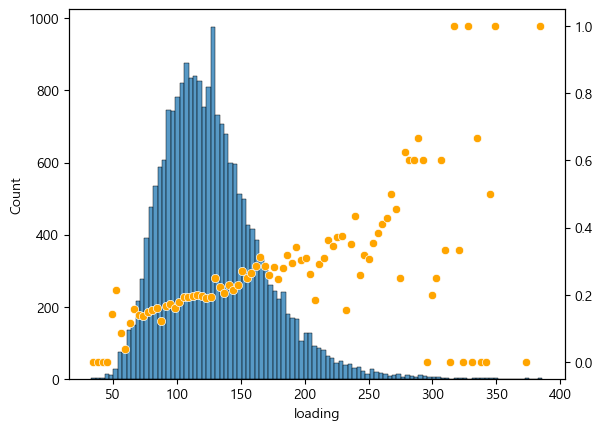

In [35]:
sns.histplot(data=df_train, x = 'loading')
s_qmean = df_train.groupby(pd.cut(df_train['loading'], bins=100))['failure'].mean()
sns.scatterplot(
    x=s_qmean.index.map(lambda x: (x.left + x.right) / 2), 
    y=s_qmean.values, ax=plt.gca().twinx(), color='orange')

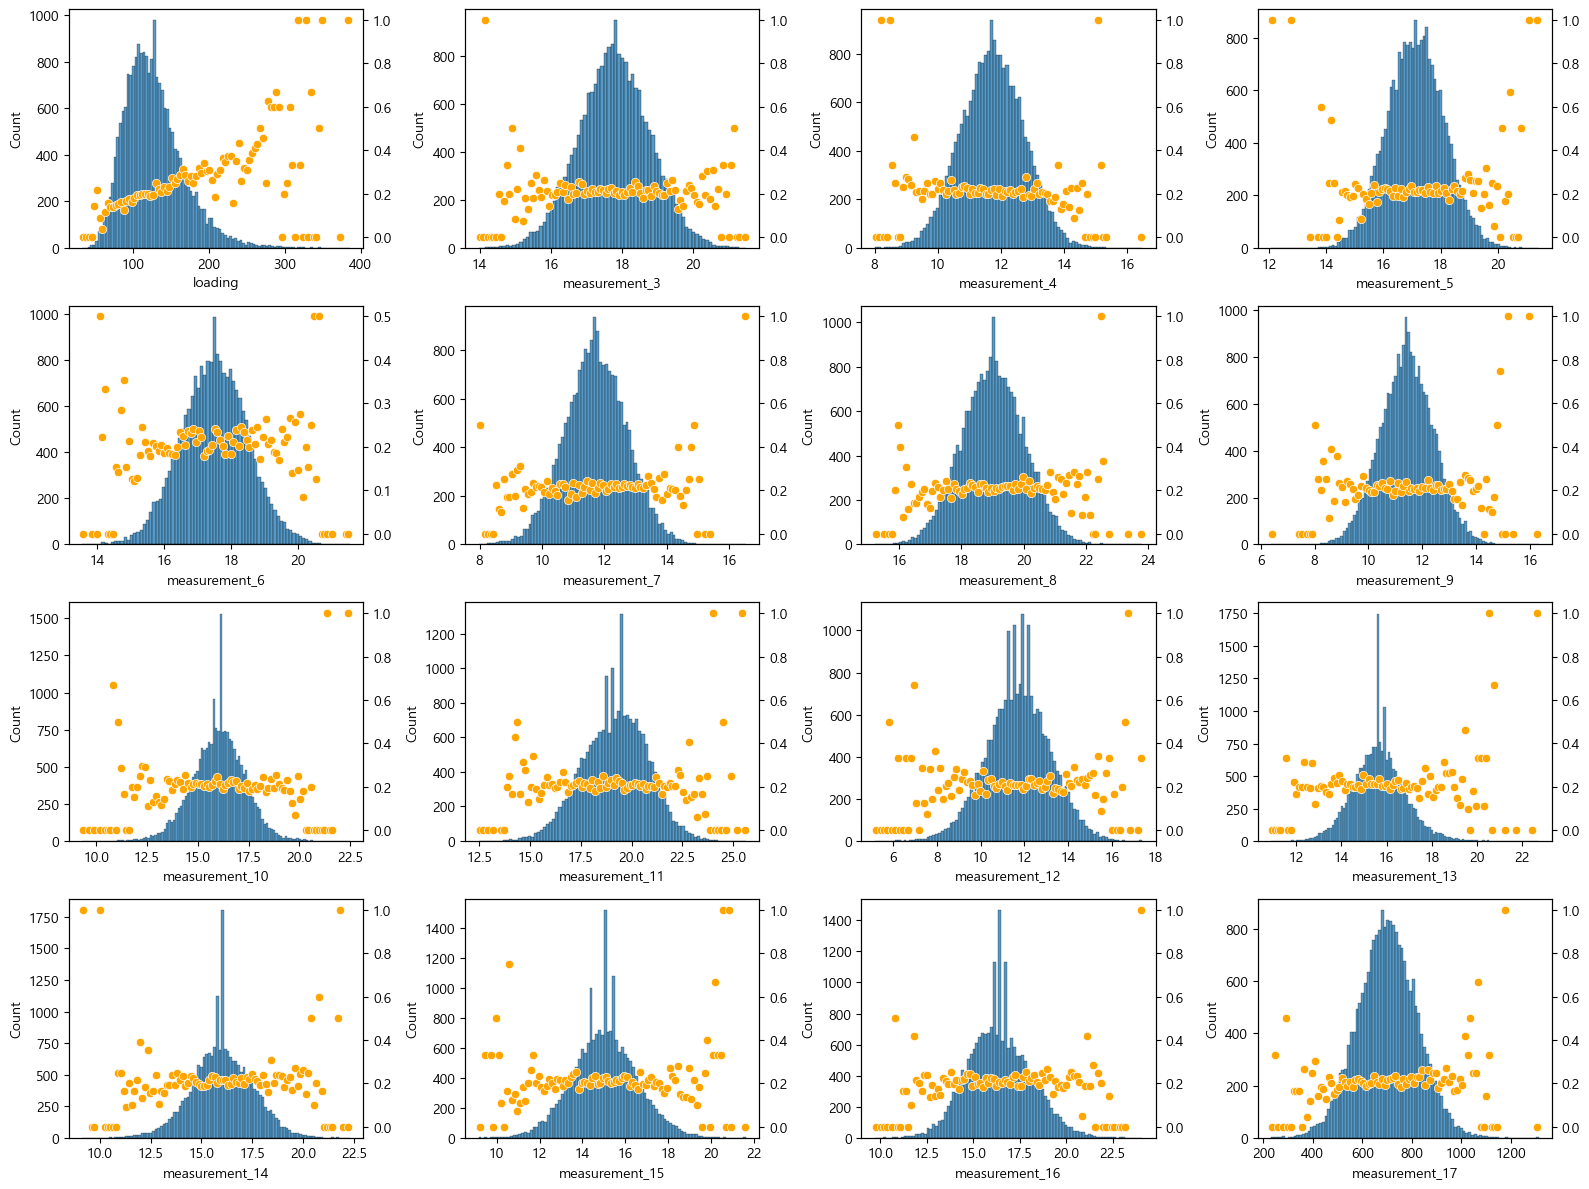

In [37]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
for i, ax in zip(['loading'] + ['measurement_{}'.format(i) for i in range(3, 18)], axes.ravel()):
    sns.histplot(data=df_train, x = i, ax=ax)
    s_qmean = df_train.groupby(pd.cut(df_train[i], bins=100))['failure'].mean()
    sns.scatterplot(
        x=s_qmean.index.map(lambda x: (x.left + x.right) / 2), 
        y=s_qmean.values, ax=ax.twinx(), color='orange')
plt.tight_layout()
plt.show()